In [1]:
from photutils import datasets
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.stats import sigma_clipped_stats
import math as math

blue_image = fits.open('messier48_20210218_055801_0_xz21lf_b_cal.fit')
green_image = fits.open('messier48_20210218_055717_0_fg1ecr_g_cal.fit')

blue_image.info()
green_image.info()

Filename: messier48_20210218_055801_0_xz21lf_b_cal.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (1336, 890)   int16 (rescales to uint16)   
Filename: messier48_20210218_055717_0_fg1ecr_g_cal.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (1336, 890)   int16 (rescales to uint16)   


In [2]:
data_b = blue_image[0].data 
mean, median, std = sigma_clipped_stats(data_b, sigma=3.0)  
print((mean, median, std))

data_g = green_image[0].data 
mean, median, std = sigma_clipped_stats(data_b, sigma=3.0)  
print((mean, median, std))


(205.19450086335817, 206.0, 18.078555354555913)
(205.19450086335817, 206.0, 18.078555354555913)


In [3]:
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data_b - median)
for col in sources.colnames:  
     sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid  ycentroid  sharpness  ... sky  peak    flux        mag     
--- --------- ----------- ---------- ... --- ----- --------- -------------
  1  13.02379 -0.17774692 0.84984083 ...   0    94 1.0146997  -0.015843787
  2  1229.547   4.5019278 0.48231753 ...   0   425 4.3195073    -1.5885855
  3 506.78316   9.9483912 0.63718038 ...   0   534 4.1310073    -1.5401399
  4 937.60593   31.618922 0.57650253 ...   0 30242  262.0477    -6.0459509
  5 264.56686   37.250215 0.38288532 ...   0    64 1.1317197   -0.13434717
  6 1035.1871   37.294983 0.63818228 ...   0 16884 128.21991    -5.2698886
  7 949.04783    41.25338 0.42137027 ...   0   144   1.32801   -0.30800338
  8 163.06925    41.48214 0.82968057 ...   0   550 5.2607653    -1.8026223
  9  82.47588   58.661102 0.52008852 ...   0   340 2.9657315    -1.1803296
 10 639.38716   72.315486 0.52939205 ...   0   308 2.5585577     -1.019988
...       ...         ...        ... ... ...   ...       ...           ...
140 982.08289   781.01955

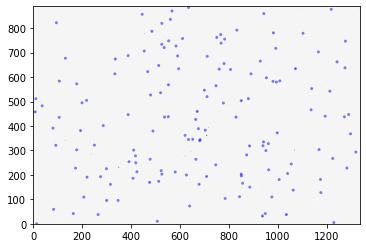

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=3.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data_b, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [5]:
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import CircularAnnulus

Star_count_listb = []
aperture_sum_listb = []
annulus_sum_listb = []
bkg_listb = []

Star_count_listg = []
aperture_sum_listg = []
annulus_sum_listg = []
bkg_listg = []

mag_listb = []
mag_listg = []
BV_list = []

t = 25

In [6]:
for source in sources:
    
    position = np.transpose((source['xcentroid'], source['ycentroid']))
    aperture = CircularAperture(position, r=3.0)
    
    phot_tableb1 = aperture_photometry(data_b, aperture)
    phot_tableg1 = aperture_photometry(data_g, aperture)
    
    for col in phot_tableb1.colnames:
        phot_tableb1[col].info.format = '%.8g'
        
    for col in phot_tableg1.colnames:
        phot_tableg1[col].info.format = '%.8g'
        
    
    annulus_aperture = CircularAnnulus(position, r_in = 4, r_out = 6)
    apers = [aperture, annulus_aperture]
    
    phot_tableb = aperture_photometry(data_b, apers)
    phot_tableg = aperture_photometry(data_g, apers)
    
    for col in phot_tableb.colnames:
        phot_tableb[col].info.format = '%.8g'
    for col in phot_tableg.colnames:
        phot_tableg[col].info.format = '%.8g'
        
    bkg_meanb = phot_tableb['aperture_sum_1'] / annulus_aperture.area
    bkg_sumb = bkg_meanb * aperture.area
    final_sumb = phot_tableb['aperture_sum_0'] - bkg_sumb
    
    bkg_meang = phot_tableg['aperture_sum_1'] / annulus_aperture.area
    bkg_sumg = bkg_meang * aperture.area
    final_sumg = phot_tableg['aperture_sum_0'] - bkg_sumg
    

    if final_sumb > 0 and final_sumg > 0:
        
        mag_b = -2.5 * math.log10(final_sumb) + math.log10(t)
        mag_g = -2.5 * math.log10(final_sumg) + math.log10(t)
        BV = mag_b - mag_g
        
        Star_count_listb.append(final_sumb)
        aperture_sum_listb.append(phot_tableb['aperture_sum_0'])
        annulus_sum_listb.append(phot_tableb['aperture_sum_1'])
        bkg_listb.append(bkg_sumb)
    
        Star_count_listg.append(final_sumg)
        aperture_sum_listg.append(phot_tableg['aperture_sum_0'])
        annulus_sum_listg.append(phot_tableg['aperture_sum_1'])
        bkg_listg.append(bkg_sumg)
    
        mag_listb.append(mag_b)
        mag_listg.append(mag_g)
        BV_list.append(BV)
        

In [7]:
print(mag_listb)

[-5.308917499125507, -7.736023003667206, -7.866348597012854, -12.022285797346605, -5.587450735181216, -11.439571821261792, -6.4282148609285725, -6.365803647705018, -7.4680909077225515, -7.1825758842825245, -10.197530457598695, -6.140899270460497, -6.667688496256011, -5.913815605887752, -7.518927364643124, -6.827119867435275, -8.671880521338833, -8.441121185038181, -6.134406250251439, -7.100278588400018, -10.670917263447546, -10.558203018584411, -8.81302076053238, -5.802516507071293, -8.10390562803676, -10.549928441084095, -8.894328302703679, -10.542219442615309, -8.223129892786979, -7.023720615099897, -6.798379985707534, -9.662943472547886, -7.075450191760362, -11.203355957903382, -9.23519750932091, -7.835898296244615, -6.920421494206121, -7.1465810355716055, -5.139097181724379, -6.409302235171776, -6.605917574012603, -6.275530426393376, -6.956615981451234, -5.785707608838929, -7.752496710299226, -5.730982454665805, -7.5906450258692395, -8.41997091351958, -6.759336478741412, -6.2310933

In [8]:
print(mag_listg)

[-5.636010504231936, -8.072018980733711, -8.288396236588367, -12.129058395921335, -6.062447816227085, -11.572725257391781, -6.872587091661437, -6.447544798147065, -8.161291305990446, -7.447178856741015, -10.283101363762036, -6.541057818816358, -7.176285106189557, -6.336662431853527, -8.153436111706927, -7.468300576525637, -8.82799816310434, -8.90443638347568, -6.6775824283676375, -7.651399703163117, -10.86545067958312, -10.674529547918436, -9.124675452686683, -6.555388823242887, -8.518112651515807, -11.430143141441548, -9.162844576666386, -10.715448885325355, -8.630472260443167, -7.9943450803098575, -7.453631339936928, -10.07316605817154, -7.6298165255387165, -11.40925227913766, -9.449965403649086, -8.414213536768813, -7.414215013066505, -7.638664485400744, -5.879394809591756, -7.111105842084491, -7.239986974171824, -6.567800529390373, -7.313564921788975, -6.339270752216045, -8.33139285300099, -6.570214915035292, -8.069889437913092, -8.71386999325712, -7.158793567289713, -6.58705442668

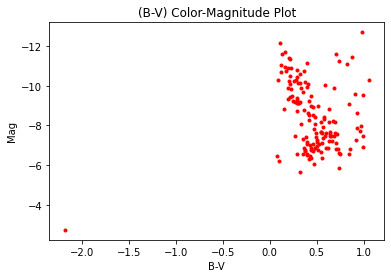

In [9]:
plt.title('(B-V) Color-Magnitude Plot')
plt.xlabel('B-V')
plt.ylabel('Mag')
plt.plot(BV_list, mag_listg, '.', color = 'red')
plt.gca().invert_yaxis()